In [13]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

## Lectura de archivos

In [14]:
desembolsos = pd.read_excel("../../db/Metas/DATOS_DESEMBOLSO.xlsx")
cancelaciones = pd.read_excel("../../db/Metas/CANCELACIONES.xlsx")
historicos = pd.read_excel("../../db/Metas/DATOS_HISTORICOS.xlsx")

In [15]:
desembolsos.head(3)

,FEC_SALDO,TIPO_CREDITO,TIPO_CLIENTE,TIPO_PAGO,MES,YEAR,BANCA,DESEMBOLSO_NETO,MONTO_DESEMBOLSADO,SUM_FACTOR_TASA_PP_COSECHA,SUM_FACTOR_PLAZO_PP_COSECHA,TICKET,TPP,PPP
0,2022-01-31,NUEVO,EXISTENTE,PAGO VOLUNTARIO,1,2022,BANCA_PERSONAS,2571936.75,2571936.75,2.559383e+07,6.003082e+07,428656.125000,9.951190,23.340706
1,2022-01-31,NUEVO,EXISTENTE,PAGO VOLUNTARIO,1,2022,BANCA_TRABAJADORES,1748400.00,1748400.00,3.062720e+07,1.415268e+08,134492.307692,17.517273,80.946465
2,2022-01-31,NUEVO,EXISTENTE,REMESA,1,2022,BANCA_PERSONAS,29210632.33,29210632.33,5.515453e+08,2.261633e+09,15447.187906,18.881663,77.424996


## Idea inicial

In [16]:
# CLIENTE NUEVO
m1 = (desembolsos["TIPO_CLIENTE"] == "NUEVO") & (desembolsos["TIPO_PAGO"] == "REMESA") & (desembolsos["BANCA"] == "BANCA_PERSONAS")
m2 = (desembolsos["TIPO_CLIENTE"] == "NUEVO") & (desembolsos["TIPO_PAGO"] == "PAGO VOLUNTARIO") & (desembolsos["BANCA"] == "BANCA_PERSONAS")
m3 = (desembolsos["TIPO_CLIENTE"] == "NUEVO") & (desembolsos["TIPO_PAGO"] == "REMESA") & (desembolsos["BANCA"] == "BANCA_TRABAJADORES")
m4 = (desembolsos["TIPO_CLIENTE"] == "NUEVO") & (desembolsos["TIPO_PAGO"] == "PAGO VOLUNTARIO") & (desembolsos["BANCA"] == "BANCA_TRABAJADORES")

# CLIENTE REACTIVADO
m5 = (desembolsos["TIPO_CLIENTE"] == "REACTIVADO") & (desembolsos["TIPO_PAGO"] == "REMESA") & (desembolsos["BANCA"] == "BANCA_PERSONAS")
m6 = (desembolsos["TIPO_CLIENTE"] == "REACTIVADO") & (desembolsos["TIPO_PAGO"] == "PAGO VOLUNTARIO") & (desembolsos["BANCA"] == "BANCA_PERSONAS")
m7 = (desembolsos["TIPO_CLIENTE"] == "REACTIVADO") & (desembolsos["TIPO_PAGO"] == "REMESA") & (desembolsos["BANCA"] == "BANCA_TRABAJADORES")
m8 = (desembolsos["TIPO_CLIENTE"] == "REACTIVADO") & (desembolsos["TIPO_PAGO"] == "PAGO VOLUNTARIO") & (desembolsos["BANCA"] == "BANCA_TRABAJADORES")

# CLIENTE EXISTENTE
m9 = (desembolsos["TIPO_CLIENTE"] == "EXISTENTE") & (desembolsos["TIPO_PAGO"] == "REMESA") & (desembolsos["BANCA"] == "BANCA_PERSONAS")
m10 = (desembolsos["TIPO_CLIENTE"] == "EXISTENTE") & (desembolsos["TIPO_PAGO"] == "PAGO VOLUNTARIO") & (desembolsos["BANCA"] == "BANCA_PERSONAS")
m11 = (desembolsos["TIPO_CLIENTE"] == "EXISTENTE") & (desembolsos["TIPO_PAGO"] == "REMESA") & (desembolsos["BANCA"] == "BANCA_TRABAJADORES")
m12 = (desembolsos["TIPO_CLIENTE"] == "EXISTENTE") & (desembolsos["TIPO_PAGO"] == "PAGO VOLUNTARIO") & (desembolsos["BANCA"] == "BANCA_TRABAJADORES")

## Encontrar proporciones

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller  
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

In [18]:
# poner el indice como marca temporal
historicos.set_index("Fecha", inplace=True)

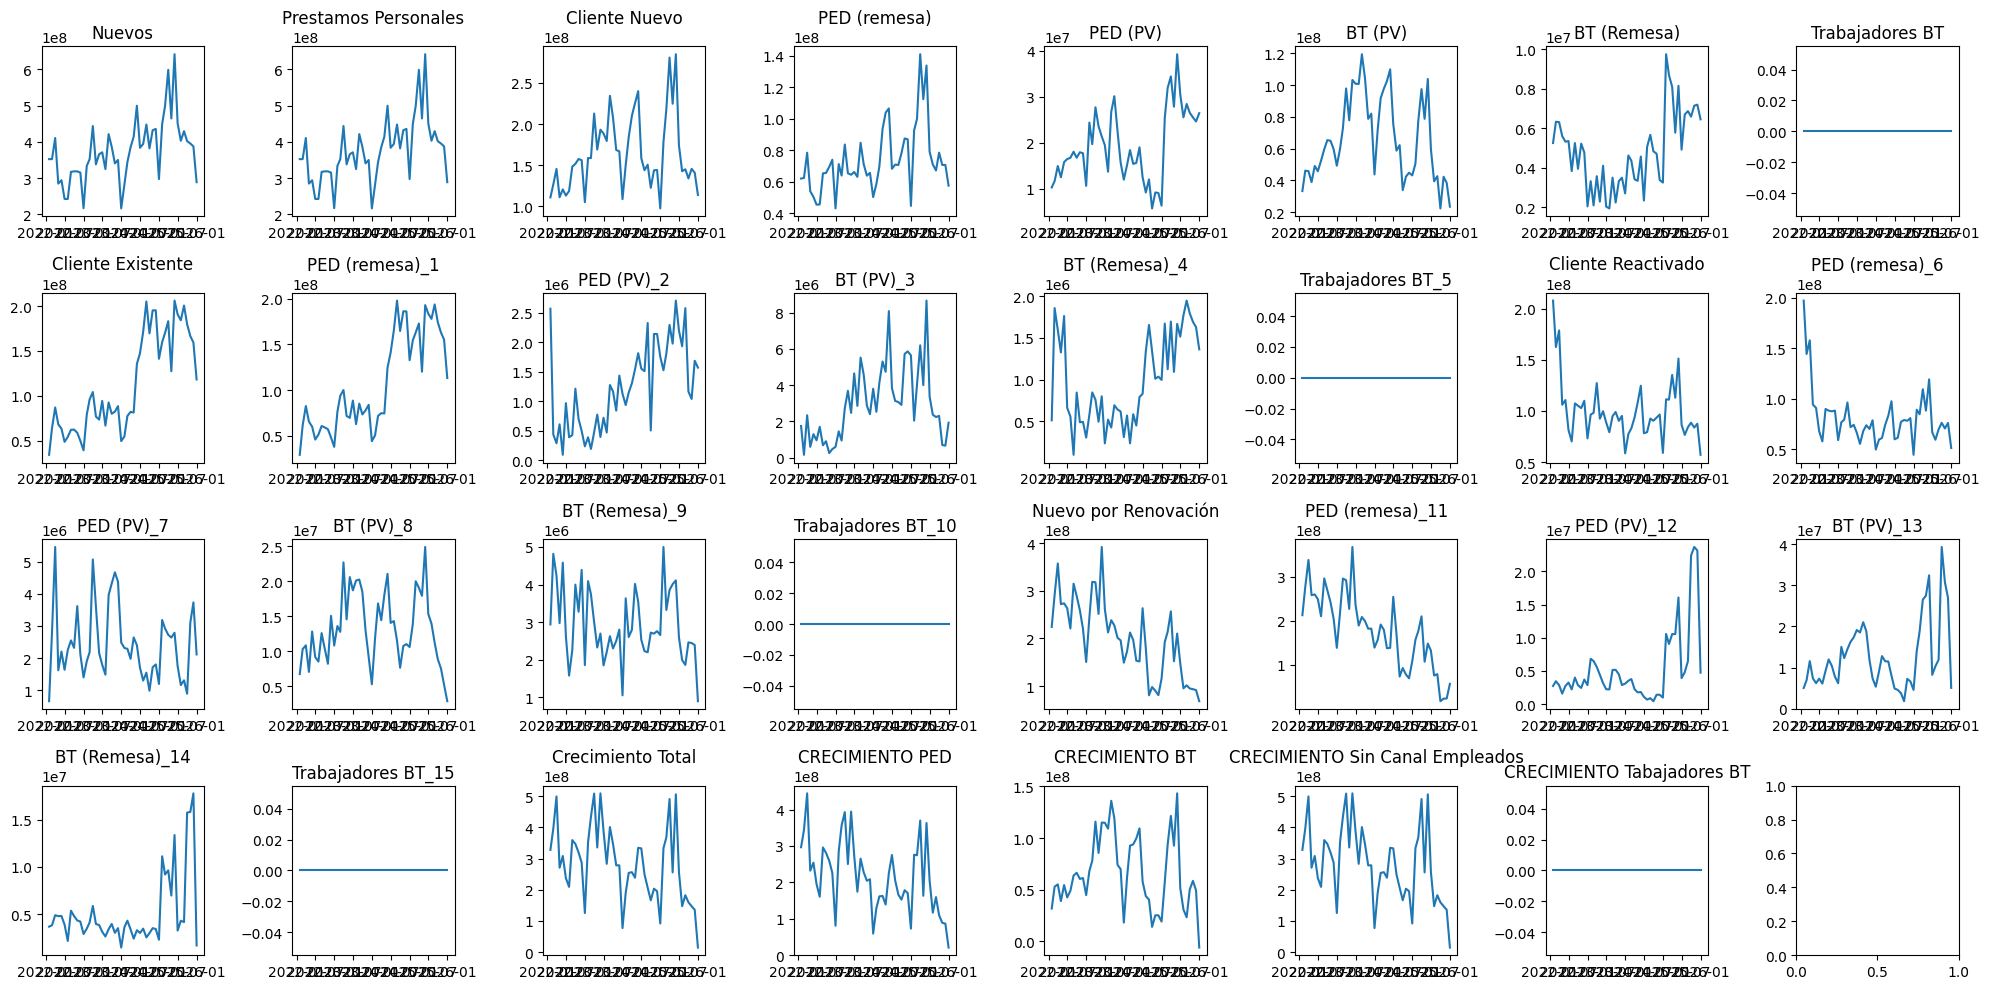

In [21]:
# Número de filas y columnas en la cuadrícula
historicos_temp = historicos.tail(12)

nrows, ncols = 4, 8
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10))  # Ajusta el tamaño de la figura según sea necesario
axes = axes.flatten()  # Convierte la matriz de ejes en una lista para iterar

# Iteramos sobre las columnas y los ejes
for idx, col in enumerate(historicos_temp.columns.tolist()):
    axes[idx].plot(historicos[col])
    axes[idx].set_title(f"{col}")

# Ajustamos el diseño para evitar superposiciones
plt.tight_layout()
plt.show()

In [ ]:
## Revisar premisas para aplicar sarima o arima
def check_stationarity(timeseries):
    result = adfuller(timeseries.dropna())
    return result[1]

def make_stationary(df, column):
    p_value = check_stationarity(df[column])
    d = 0
    while p_value > 0.05:
        df[column] = df[column].diff().dropna()
        p_value = check_stationarity(df[column])
        d += 1
        print(f'{d}-esima diferneciación: p-valor = {p_value}')
    return df, d


# Hacer estacionaria la serie de tiempo
constantes = []
for col in historicos.columns.tolist():
    try:
        historicos_estacionaria, d = make_stationary(historicos.copy(), col)
    except:
        constantes.append(col)

## Hallar parámetros para modelo

In [ ]:
best_aic_indicator = float("inf")
best_pdq_indicator = None
best_seasonal_pdq_indicator = None

p = q = range(0, 3)
d = range(0,1)
pdq = list(itertools.product(p, d, q))

# seasonal parameter
seasonal_pdq = [(x[0], x[1], x[2], 3) for x in pdq]

parametros = {}
# guardar en nomnre col, parámetro y parámetro estacionario

for col in historicos_estacionaria.columns.tolist():
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = SARIMAX(historicos_estacionaria[col], order=param,
                            seasonal_order=param_seasonal,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
                results = mod.fit(disp=False)
                if results.aic < best_aic_indicator:
                    best_aic_indicator = results.aic
                    best_pdq_indicator = param
                    best_seasonal_pdq_indicator = param_seasonal
            except Exception as e:
                print(f"Error with parameters {param} & {param_seasonal}: {e}")
                continue
    parametros[col] = (param, param_seasonal)

### Correr modelo

In [10]:
from matplotlib.backends.backend_pdf import PdfPages

# Crear DataFrame para almacenar las predicciones
predicciones_df = pd.DataFrame(index=pd.date_range(start='2025-01-01', periods=12, freq='M'))

# Crear archivo PDF
with PdfPages("arima_predicciones.pdf") as pdf:
    for col in historicos_estacionaria.columns.tolist():
        # Crear el modelo SARIMAX
        modelo = SARIMAX(historicos_estacionaria[col],
                         order=parametros.get(col)[0],
                         seasonal_order=parametros.get(col)[1],
                         enforce_invertibility=False,
                         enforce_stationarity=False)

        modelo_fitted = modelo.fit(disp=False)
        pred = modelo_fitted.forecast(steps=12)
        
        # Crear índice de fechas desde enero 2025 a diciembre 2025 para las predicciones
        pred.index = pd.date_range(start='2025-01-01', periods=12, freq='M')
        
        # Almacenar las predicciones en el DataFrame
        predicciones_df[col] = pred
        
        # Primera figura: gráfico de predicciones
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(pred, label='ARIMA ORGÁNICO', color='red')
        ax.set_title(f'ARIMA ORGÁNICO - {col}')
        ax.legend()

        # Guardar solo el gráfico en el PDF (media página)
        pdf.savefig(fig)
        plt.close(fig)
        
        # Segunda figura: resumen del modelo
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.axis('off')  # Ocultar los ejes
        summary_text = modelo_fitted.summary().as_text()
        plt.figtext(0.1, 0.5, summary_text, fontsize=10, ha="left", va="center", wrap=True)

        # Guardar solo el resumen en el PDF (media página)
        pdf.savefig(fig)
        plt.close(fig)


In [12]:
predicciones_df

,Nuevos,Prestamos Personales,Cliente Nuevo,PED (remesa),PED (PV),BT (PV),BT (Remesa),Trabajadores BT,Cliente Existente,PED (remesa)_1,...,PED (remesa)_11,PED (PV)_12,BT (PV)_13,BT (Remesa)_14,Trabajadores BT_15,Crecimiento Total,CRECIMIENTO PED,CRECIMIENTO BT,CRECIMIENTO Sin Canal Empleados,CRECIMIENTO Tabajadores BT
2025-01-31,2.099735e+07,2.099735e+07,-9.610405e+07,6.794323e+07,1.803848e+07,5.254939e+07,3.851556e+06,0.0,1.851755e+08,1.662625e+08,...,1.140525e+08,1.215552e+06,5.453435e+06,3.078602e+06,0.0,1.095272e+08,1.369645e+08,3.445460e+07,1.095272e+08,0.0
2025-02-28,-5.034795e+08,-5.034795e+08,8.898005e+07,8.318414e+07,4.066741e+07,6.349860e+07,4.884265e+06,0.0,2.084574e+08,1.891579e+08,...,9.809896e+07,9.854023e+05,-3.217394e+04,3.222758e+06,0.0,1.381753e+08,2.207549e+08,3.353907e+07,1.381753e+08,0.0
2025-03-31,-2.673025e+09,-2.673025e+09,7.539323e+08,1.013029e+08,4.827034e+07,3.340370e+07,3.437219e+06,0.0,1.759963e+08,1.635454e+08,...,1.179267e+08,6.628817e+05,-4.487378e+06,3.022546e+06,0.0,1.136195e+08,2.056447e+08,3.218469e+07,1.136195e+08,0.0
2025-04-30,-7.915674e+09,-7.915674e+09,1.815635e+09,1.106942e+08,2.489639e+07,3.610095e+07,3.935005e+06,0.0,2.107022e+08,1.990840e+08,...,9.422427e+07,6.949742e+05,-1.737352e+06,3.239770e+06,0.0,1.178934e+08,2.212377e+08,2.783610e+07,1.178934e+08,0.0
2025-05-31,-2.383272e+10,-2.383272e+10,1.915534e+09,1.098707e+08,-5.785287e+07,3.759601e+07,4.104532e+06,0.0,2.418134e+08,2.226545e+08,...,7.251742e+07,6.617719e+05,1.868567e+06,3.140495e+06,0.0,1.253560e+08,2.312936e+08,3.406371e+07,1.253560e+08,0.0
2025-06-30,-6.761485e+10,-6.761485e+10,-1.447576e+09,7.440271e+07,-1.828220e+08,1.806797e+07,3.149034e+06,0.0,2.022185e+08,2.012797e+08,...,9.393187e+07,4.151071e+05,1.147014e+07,2.778836e+06,0.0,9.219927e+07,1.690971e+08,1.997801e+07,9.219927e+07,0.0
2025-07-31,-1.936803e+11,-1.936803e+11,-9.752579e+09,8.639297e+07,-2.362914e+08,2.336348e+07,3.975632e+06,0.0,2.417121e+08,2.378811e+08,...,8.644563e+07,5.341527e+05,2.825384e+07,3.147360e+06,0.0,9.195320e+07,1.594904e+08,2.796782e+07,9.195320e+07,0.0
2025-08-31,-5.470194e+11,-5.470194e+11,-1.766501e+10,9.266589e+07,-5.276945e+07,2.469642e+07,4.367522e+06,0.0,2.762497e+08,2.600008e+08,...,7.332714e+07,4.951246e+05,3.616616e+07,3.046068e+06,0.0,1.039529e+08,1.698621e+08,3.145050e+07,1.039529e+08,0.0
2025-09-30,-1.553350e+12,-1.553350e+12,-8.268466e+09,9.917431e+07,4.754693e+08,9.214397e+06,3.335234e+06,0.0,2.309730e+08,2.335167e+08,...,8.683680e+07,3.329013e+05,2.625198e+07,2.799870e+06,0.0,8.326612e+07,1.272495e+08,2.722347e+07,8.326612e+07,0.0
2025-10-31,-4.394053e+12,-4.394053e+12,4.105392e+10,1.075464e+08,1.189318e+09,1.344630e+07,3.921760e+06,0.0,2.756710e+08,2.753809e+08,...,7.999222e+07,4.033528e+05,-1.017608e+07,2.989039e+06,0.0,8.438367e+07,1.423197e+08,2.535600e+07,8.438367e+07,0.0


### Almacenar predicciones orgánicas